In [1]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import functional as transformF
import torchvision.utils as vutils
from torchvision.io import read_image,ImageReadMode
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt 
import gc
from IPython.display import clear_output

In [2]:
from decoder import Decoder
from discriminator import Discriminator
from patchdisc import PatchDiscriminator
from encoder import Encoder
from UNet import Unet

100
100


In [3]:
PATH="C:\\Users\\vicin\Desktop\\PoliTo\\ML_for_CV\\CGAN"


In [4]:
class CustomDataset(Dataset):
    def __init__(self, img_dir,transforms=None, target_transforms=None):
        self.img_dir=img_dir
        self.transforms=transforms
        self.target_transforms=target_transforms
        self.imgs=[]
        self.imgs.extend([self.img_dir+'\\'+i for i in os.listdir(self.img_dir) if i.endswith('.jpg')])
        print(self.imgs)

    def __getitem__(self, index):
        img=read_image(self.imgs[index]).float()
        img/=255

        col,seg=img.split([256,256], 2)
        return col,seg
    
    def __len__(self):
        return len(self.imgs)
    
dataset_train=CustomDataset(PATH+'\\cityscapes\\cityscapes_data\\train')
#dataset_train=dataset_train[100][:]
dataset_train,_=random_split(dataset_train,[500,len(dataset_train)-500])
dataset_val=CustomDataset(PATH+'\\cityscapes\\cityscapes_data\\val')

dataloader_train=DataLoader(dataset_train,16, shuffle=True)
dataloader_val=DataLoader(dataset_val,16, shuffle=True)

['C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\10.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\100.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1000.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1001.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1002.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1003.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1004.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1005.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1006.jpg', 'C:\\

In [5]:
class DNSDataset(Dataset):
    def __init__(self, img_dir, transforms=None, target_transforms=None):
        self.img_dir=img_dir
        self.imgs_depth=[]
        self.imgs_norm=[]
        self.imgs_seg=[]
        self.imgs_col=[]

        self.imgs_depth.extend([self.img_dir + '\\Depth\\'+i for i in os.listdir(self.img_dir+'\\Depth') if i.endswith('.png')])
        self.imgs_norm.extend([self.img_dir + '\\Normal\\'+i for i in os.listdir(self.img_dir+'\\Normal') if i.endswith('.png')])
        self.imgs_seg.extend([self.img_dir + '\\Segmentation\\'+i for i in os.listdir(self.img_dir+'\\Segmentation') if i.endswith('.png')])
        self.imgs_col.extend([self.img_dir + '\\Default\\'+i for i in os.listdir(self.img_dir+'\\Default') if i.endswith('.png')])
        
        self.transforms=transforms
        self.target_transforms=target_transforms
    def __getitem__(self, index) -> torch.Tensor:
        norm=transformF.to_tensor(Image.open(self.imgs_norm[index]))[0:3]
        print(norm.shape)
        depth=transformF.to_tensor(transformF.to_grayscale(Image.open(self.imgs_depth[index])))
        print(depth.shape)
        col=transformF.to_tensor(Image.open(self.imgs_col[index]))[0:3]

        seg=transformF.to_tensor(Image.open(self.imgs_seg[index]))[0:3]
        print(seg.shape)
        
        return torch.cat([depth,norm,seg],0), col
        
    def __len__(self):
        return len(self.imgs_col)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


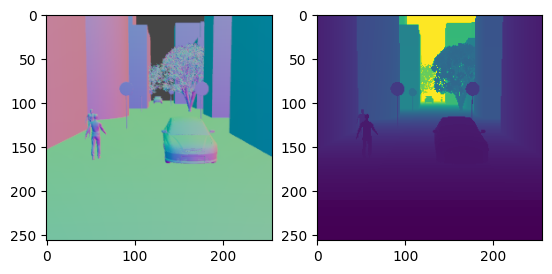

In [6]:
#Test Dataset

train_dataset=DNSDataset(PATH+'\\dataset\\Cam 1')

img0_norm=train_dataset[0][0].split([1,3,3])[1]
img0_depth=train_dataset[0][0].split([1,3,3])[0]

plt.subplot(121)
plt.imshow(img0_norm.permute(1,2,0))
plt.subplot(122)
plt.imshow(img0_depth.permute(1,2,0))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
### TEST DECODER ###
r=torch.randn(16,100,2,2).cuda()

print(r.shape)

encoder=Encoder().cuda()
decoder=Decoder().cuda()

discriminator=Discriminator().cuda()

encoder.apply(weights_init)
decoder.apply(weights_init)
discriminator.apply(weights_init)

# print(discriminator(decoder(r)).shape)
# print(encoder(decoder(r)).shape)
# print(decoder(r).shape)



torch.Size([16, 100, 2, 2])
torch.Size([1, 1, 4, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


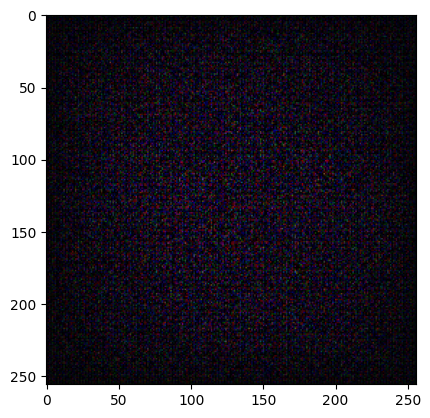

In [9]:
plt.imshow(decoder(r)[0].cpu().detach().permute([1,2,0]))

In [10]:
optimizerDisc=optim.Adam(discriminator.parameters(), 0.0002, (0.5,0.9))
optimizerDec=optim.Adam(decoder.parameters(), 0.0002, (0.5,0.999))

enc_dec_param=list(decoder.parameters())+list(encoder.parameters())
optimizerEncDec=optim.Adam(enc_dec_param, 0.0002, (0.5,0.999))


criterion=nn.BCELoss()
criterion_encoder=nn.SmoothL1Loss()

TypeError: Adam.__init__() missing 1 required positional argument: 'params'

In [ ]:
### Train-Loop GAN ###
def optimize_GAN():
    global decoder, discriminator, dataloader_train
    accuracy=0
    for (data,seg) in dataloader_train:
        batch_size=data.shape[0]
        data_gpu=data.cuda()
        seg_gpu=seg.cuda()

        latent_batch=encoder(seg_gpu)

        fake_data=decoder(latent_batch)

        ### Train Discriminator ### 
        discriminator.zero_grad()
        decoder.zero_grad()
        
        label1=torch.full((batch_size,), 1.).cuda() #Etichetta immagini reali
        output1=discriminator(data_gpu).view(-1) # predizioni
        errDisc_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.eq(1.).sum().item()

        label2=torch.full((batch_size,), 0.).cuda()
        output2=discriminator(fake_data.detach()).view(-1)
        errDisc_fake=criterion(output2,label2)

        accuracy+=output1.eq(0.).sum().item()

        
        errDisc=errDisc_real+errDisc_fake
        errDisc.backward()
        optimizerDisc.step()
        
        ### Train Decoder ###
        
        output3=discriminator(fake_data).view(-1)
        errDec=criterion(output3, label1)

        errDec.backward()
        optimizerDec.step()
    return accuracy/len(dataloader_train.dataset), fake_data[0]

In [ ]:
def optimize_encoder_decoder():
    global encoder, decoder, discriminator, dataloader_train
    accuracy=0
    for (data,seg) in dataloader_train:
        batch_size=data.shape[0]
        data_gpu=data.cuda()
        seg_gpu=seg.cuda()

        latent_batch=encoder(seg_gpu)

        fake_data=decoder(latent_batch)

        ### Train Discriminator ### 
        discriminator.zero_grad()
        decoder.zero_grad()
        encoder.zero_grad()
        

        label1=torch.full((batch_size,), 1.).cuda() #Etichetta immagini reali
        output1=discriminator(torch.cat([data_gpu,seg_gpu], dim=1)).view(-1) # predizioni
        errDisc_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.eq(1.).sum().item()

        label2=torch.full((batch_size,), 0.).cuda()
        output2=discriminator(torch.cat([fake_data.detach(),seg_gpu], dim=1)).view(-1)
        errDisc_fake=criterion(output2,label2)

        accuracy+=output1.eq(0.).sum().item()

        
        errDisc=errDisc_real+errDisc_fake
        errDisc.backward()
        optimizerDisc.step()
        
        ### Train Decoder ###
        
        
        # errDec=criterion_encoder(fake_data, data_gpu)

        # errDec.backward()
        # optimizerEncDec.step()

        output3=discriminator(torch.cat([fake_data, seg_gpu], dim=1)).view(-1)
        errGen=criterion(output3, label1)
        errGen.backward()
        optimizerEncDec.step()
        fake_data.cpu()
        data_gpu.cpu()
        seg_gpu.cpu()
        gc.collect()
        torch.cuda.empty_cache()
        
    return accuracy/len(dataloader_train.dataset), fake_data[0], seg[0]

In [ ]:

### Train Loop ###
epochs=500
start_epoch=0
if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      discriminator.load_state_dict(state["Discriminator"])
      decoder.load_state_dict(state["Decoder"])
      encoder.load_state_dict(state["Encoder"])
      optimizerDisc.load_state_dict(state["optimizerD_state_dict"])
      optimizerEncDec.load_state_dict(state["optimizerED_state_dict"])
      start_epoch=state["epoch"]
  except:
    print("Error in load")



for i in range(start_epoch, epochs):
    print("Epoch ",i)
    accuracy, fake_data, seg=optimize_encoder_decoder()
    
    clear_output(wait=True)
    print("Saving...")
    torch.save({"Discriminator":discriminator.state_dict(),
    "optimizerD_state_dict":optimizerDisc.state_dict(),
    "Decoder":decoder.state_dict(),
    "Encoder":encoder.state_dict(),
    "optimizerED_state_dict":optimizerEncDec.state_dict(),
    "epoch":i},
    "./neverStreets")
    print(accuracy)
    
    plt.subplot(121)
    plt.imshow(fake_data.cpu().detach().permute([1,2,0]))
    plt.subplot(122)
    plt.imshow(seg.cpu().detach().permute([1,2,0]))
    plt.show()

Loading...
Epoch  60


KeyboardInterrupt: 

Loading...


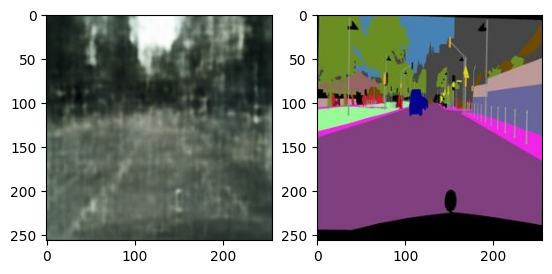

In [ ]:
import random
decoder=Decoder().cuda()
encoder=Encoder().cuda()

if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      encoder.load_state_dict(state["Encoder"])
      #disc.load_state_dict(state["Discriminator"])
      decoder.load_state_dict(state["Decoder"])
      #optimizerDisc.load_state_dict(state["optimizerD_state_dict"])
      #optimizerDec.load_state_dict(state["optimizerG_state_dict"])
      #start_epoch=state["epoch"]
  except:
    print("Error in load")


data,seg=next(iter(dataloader_val))
#fake_data=decoder(torch.randn([16,100,1,1], device='cuda'))
r=random.randint(0, len(data)-1)
fake_data=decoder(encoder(seg.cuda()))
to_image=transforms.ToPILImage()
plt.subplot(121)
plt.imshow(to_image(fake_data[r].clip(0,1).cpu()))
plt.subplot(122)
plt.imshow(to_image(seg[r].clip(0,1).cpu()))